# Financial bars at the age of deep learning

![candlestick_vs_tensor](visual/vsbar.jpg)

At the age of machine learning and deep learning the representation of financial data needs new approaches. Candlesticks for example originated from Japanese rice merchants, and were first used in the 18th century. Obviously they wasn't developed for neural networks. They are very well suited to visualize the price movement, but hide possibly important information. Models process data differently, and they can "understand" features that is hard to apprehend in bulk by humans.

We recognize patterns in images, neural networks recognise patterns in multidimensional datasets. Of course we can use the same OHLC data to display a bar chart and feed to our network, but we can derive very different additional information from the price movement other than the open, high, low and close price of the sampled bar.

In this notebook I will share some ideas about the possibile data transformations for neural networks, and will flavor it with some sacrilege at the end, but there are plenty of other options worth to examine. Stationarity, homoscedacity or uncorrelated features are very important for some forecasting methods, but neural networks doesn't require such strong conditions. These conditions can improve the performance of some models, while others are built to deal with heteroscedastic data like the mixture density network in my earlier article.

In the notebook we will use only ask price. Combining it with bid price, volume or other data could lead to many new features.

This article insn't the implementation of the ideas in the book of Marcos Lopez de Prado. That is an awesome book, and you can find articles about the topics in it. For example this one from Maks Ivanov, which explanes time bars, tick bars, volume bars, dollar bars and the imbalance bars.

We follow a different approach, but the ideas in this article can be mixed with the above mentined techniques. For simplicity we will use time bars, but for most examples any of the above mentioned alternative bar sampling could be used.

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from scipy.stats import spearmanr
import seaborn as sns
import os
from IPython.display import Image

## Dataset

Our raw data is the USD/JPY tick ask price from 2016. We will examine resampling and feature building teqhniques, but won't train a model, so we don't use large dataset. The source of the tick data is dukascopy.com.

In [2]:
# read tick data
df = pd.read_csv('USDJPY_tick.csv', sep=",")

In [3]:
# time column to index
df['ctime']  = pd.to_datetime(df['Timestamp'])
df = df.set_index('ctime')
df = df.drop(columns=['Timestamp'])
df

,Ask price
ctime,
2016-01-03 22:00:01,120.233
2016-01-03 22:00:02,120.233
2016-01-03 22:00:04,120.232
2016-01-03 22:00:11,120.233
2016-01-03 22:00:25,120.230
...,...
2016-02-29 23:59:52,112.417
2016-02-29 23:59:52,112.417
2016-02-29 23:59:52,112.417


## Good old candlesticks

Why we need bars at all? The main role of bars is to filter noise, compress information, and transform the data to a human or model comprehensible form. This is true to all bar types, not only candlesticks. Noise filtering and information compressing helps us (or doesn't) to see the price movement, recognize trends, support and resistance levels, volatile regions and candlestick patterns (what is in my opinion more misleading than useful). Unfortunatelly because of the filtering and compressing lots of important information vanishes, or we get false impressions. For example the candlestick tailes are much thiner than the body, what visualy implies that most of the price action happened in the region of the body, but it isn't always true, sometimes most of the price action happenes in the upper or lower tail or has multimodal distribution.

In [4]:
# resample 15 min data
df_15 = df['Ask price'].resample('15Min').ohlc().iloc[100:150]

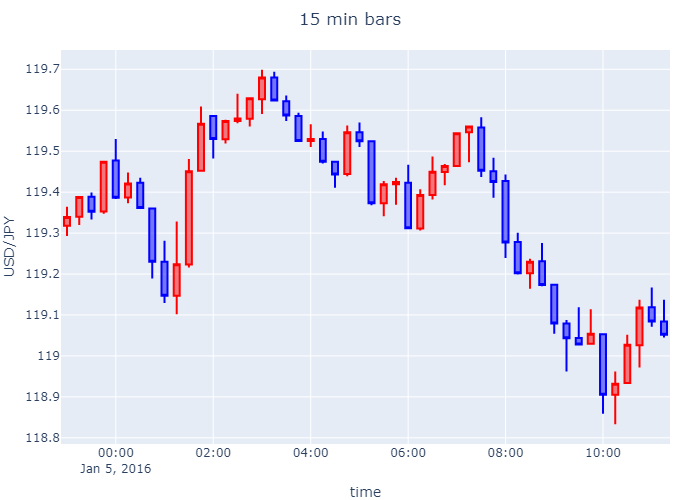

In [5]:
fig = go.Figure(data=[go.Candlestick(x=df_15.index,
                open=df_15['open'],
                high=df_15['high'],
                low=df_15['low'],
                close=df_15['close'],
                increasing_line_color= 'red', decreasing_line_color= 'blue')])
fig.update(layout_xaxis_rangeslider_visible=False)
fig.update_layout(
    xaxis_title="time",
    yaxis_title="USD/JPY",
    title_text='15 min bars', 
    title_x=0.5,
    margin=dict(l=0,r=30,b=0,t=50))
img_bytes = fig.to_image(format="png")
Image(img_bytes)

In [6]:
# release df_15, will not use later
del df_15

## Bar tensors

When we sample "bars" for models the main goal is similar to sampling bars for human visualization. Most of the times we want less noisy data, less data to speed up calculation, and features that we hope will improve our model's performance. Of course we can always use raw tick data, and I personally prefer tick charts to bars when watching shorter price movements. Why use bars then at all when training models?

- One reason is the required computation power. Depending on the range of the bar and the number of parameters, bar data can be only a fraction in size of the original tick data.
- Models based on LSTM layers have problems with long sequences, and the frequency of tick data is simply too much for them if the goal forecast timeframe is relativelly large. But even CNN based Wavenet models have limits.
- We can produce features from tick data which can improve model performance.

The number of features of a bar is arbitrary. We should consider the bars as tensors. We will use one dimensional vectors as bars, but it isn't difficult to make up multidimensional bars if we want, and our model is capable to utilize them. Just an example for a 2XN dimension bar: The N represents the number of features we derive from the tick data, and the two layers are the ask and bid data. Of course you need a proper model to use this arrangement of data, because the same data could have 1X2N dimension, where the features derived from ask and bid ticks are concatenated along the same axis. But if you use 2XN dimension input you can use a Conv1D layer over it similar to the Conv2D convolution of an RGB image. But we can expand our features in a very diferent dimension. We can use the last tick data as an anchor point, and instead of sampling only from one timeframe, we can use derived features or statistics of different timeframes ending at this anchor tick. When using deep learning models we should consider the layers of the model when building the bars, because different layers can explore different connections. 

What kind of new features can we add to our bar tensors? Any kind we can imagine and turns out to be useful. The open, high, low, close (first, max, last, min in the code) can remain among our features, why not, but if you don't care about slippage between bars you can even omit the open price. Of course if you resample daily stock prices you shouldn't drop it, but the open price of a 1 minute bar may be not so important. A feature can be the mean of the ticks in the bar range, or the volume weighted mean of the ticks. If we use time-based bars, then the number of ticks during the time-range can be an other feature. If we use tick bars, then the time-range of the ticks in the bar can be a feature. We can use the standard deviation of ticks in a bar to compare the volatility of bars and Pearson correlation between the price and the time axis to estimate the monotonity of the price movement. Log return can be an other feature, and we will calculate the quantiles to estimate the regions where the tick price resides in the bar. Of course we could generate other features. If you have something in mind you can share it in the comments or on Linkedin :)

Ok, lets build our "bars"!:

In [7]:
# instantiate 5 min resampler object
rs_5m = df.resample('5min')

In [8]:
# build sampler functions
# instead of lambda function use normal function to have the same column name
def bar_len(x): return len(x)

def bar_quantile_25(x): return x.quantile(0.25)
def bar_quantile_75(x): return x.quantile(0.75)
def bar_spearman(x): 
    corr, p_value = spearmanr(x, np.arange(len(x)))
    return corr

In [9]:
# sample the 5 min dataset with the following columns:
df_5m = rs_5m.agg({ 'Ask price':    ['first',           # open
                                    'max',              # high
                                    'min',              # low
                                    'last',             # close
                                    'mean',             # mean
                                    'std',              # standard deviation
                                    bar_len,            # number of ticks
                                    bar_quantile_25,    # Q1
                                    bar_quantile_75,    # Q3
                                    bar_spearman]})     # Spearman correlation
# simplify dataset as we use only the ask price                                  
df_5m = df_5m['Ask price']

In [10]:
# logreturn of the bar
df_5m['bar_log_r'] = np.log(df_5m['last']/df_5m['first']) # log return
df_5m

,first,max,min,last,mean,std,bar_len,bar_quantile_25,bar_quantile_75,bar_spearman,bar_log_r
ctime,,,,,,,,,,,
2016-01-03 22:00:00,120.233,120.234,120.227,120.228,120.231125,0.001963,24.0,120.23000,120.23300,-0.427193,-0.000042
2016-01-03 22:05:00,120.229,120.242,120.221,120.231,120.232787,0.005567,94.0,120.22900,120.23700,0.792465,0.000017
2016-01-03 22:10:00,120.233,120.244,120.221,120.234,120.233771,0.007161,70.0,120.22650,120.23975,-0.653239,0.000008
2016-01-03 22:15:00,120.234,120.256,120.225,120.248,120.243313,0.006891,144.0,120.24100,120.24800,0.549631,0.000116
2016-01-03 22:20:00,120.248,120.266,120.243,120.257,120.250207,0.004880,150.0,120.24700,120.25200,0.550134,0.000075
...,...,...,...,...,...,...,...,...,...,...,...
2016-02-29 23:35:00,112.382,112.445,112.382,112.433,112.411838,0.017112,241.0,112.39700,112.42700,0.827126,0.000454
2016-02-29 23:40:00,112.433,112.440,112.422,112.436,112.428974,0.005072,231.0,112.42500,112.43300,0.251933,0.000027
2016-02-29 23:45:00,112.436,112.443,112.358,112.403,112.395758,0.025452,277.0,112.37200,112.41300,-0.636658,-0.000294


In [11]:
# Fig1
fig1 = make_subplots(specs=[[{"secondary_y": True}]])
fig1.add_trace(go.Candlestick(x=df_5m[5050:5100].index,
                open=df_5m[5050:5100]['first'],
                high=df_5m[5050:5100]['max'],
                low=df_5m[5050:5100]['min'],
                close=df_5m[5050:5100]['last'],
                increasing_line_color= 'red', decreasing_line_color= 'blue',
                name="OHLC"))
fig1.add_trace(go.Candlestick(x=df_5m[5050:5100].index,
                open=df_5m[5050:5100]['bar_quantile_75'],
                high=df_5m[5050:5100]['bar_quantile_75'],
                low=df_5m[5050:5100]['bar_quantile_25'],
                close=df_5m[5050:5100]['bar_quantile_25'],
                increasing_line_color= 'gray', decreasing_line_color= 'gray',
                name="25-75 quantiles"))
fig1.add_trace(go.Scatter(
                x=df_5m[5050:5100].index,
                y=df_5m[5050:5100]['mean'],
                name="bar mean"))

fig1.update(layout_xaxis_rangeslider_visible=False)
fig1.update_layout(
    autosize=False,
    width=1200,
    height=600,
    margin=dict(l=10,r=10,b=10,t=10))
fig1.show()

# Fig2
fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig2.add_trace(go.Bar(
                x=df_5m[5050:5100].index,
                y=df_5m[5050:5100]['bar_len'],
                marker_color='rgb(26, 118, 255)',
                marker_line_color='rgb(8,48,107)',
                marker_line_width=5,
                opacity=0.6,
                name="tick number"))                
fig2.add_trace(go.Bar(
                x=df_5m[5050:5100].index,
                y=df_5m[5050:5100]['bar_spearman'],
                marker_color='red',
                name="price-time corr"),
                secondary_y=True)

fig2.update_layout(
    barmode='group',
    autosize=False,
    width=1200,
    height=200,
    margin=dict(l=10,r=10,b=10,t=10))
fig2.show()

# Fig3
fig3 = make_subplots(specs=[[{"secondary_y": True}]])
fig3.add_trace(go.Bar(
                x=df_5m[5050:5100].index,
                y=df_5m[5050:5100]['std'],
                marker_color='rgb(26, 118, 255)',
                marker_line_color='rgb(8,48,107)',
                marker_line_width=5,
                opacity=0.6,
                name="tick std of bar",
                showlegend=True))
fig3.add_trace(go.Bar(
                x=df_5m[5050:5100].index,
                y=df_5m[5050:5100]['bar_log_r'],
                marker_color='blue',
                name="bar log return"),
                secondary_y=True)

fig3.update_layout(
    barmode='group',
    autosize=False,
    width=1200,
    height=200,
    margin=dict(l=10,r=10,b=10,t=10))
fig3.show()

The chart above displays a sequence of our features. Some observations: The body of the candlestick shows a bit different pattern than the Q1-Q3 range. The log returns not surprisingly move together with the Spearman correlation, and the highest standard deviations of tick prices are more tipical of bars with more ticks. The displayed sequence is short and analizing these connections more deeply isn't the goal of the notebook, but we expect(/hope) that the new features will improve the performance of our model.

## Refine the features

In our features we have log returns and price informations. For neural networks all of them can be usefull, and depending on our forecasted features one can be more important than the other. This article explaines the advantages of log returns https://quantivity.wordpress.com/2011/02/21/why-log-returns/. In the case of our dataset these advantages can be extended. In the next table we can see the correlations and standard deviations of our price features. The correlations are almost one, and up to the second decimal the standard deviations are are the same because relative to the long term price changes the price features in a bar are very close to each other. This means that the model have to find usefull patterns among very similar numbers.

In [28]:
# correlation is almost 1
df_5m[['first', 'max', 'min', 'last', 'mean','bar_quantile_25', 'bar_quantile_75']].corr(method='pearson')

,first,max,min,last,mean,bar_quantile_25,bar_quantile_75
first,1.000000,0.999848,0.999870,0.999770,0.999913,0.999902,0.999891
max,0.999848,1.000000,0.999757,0.999888,0.999931,0.999867,0.999969
min,0.999870,0.999757,1.000000,0.999860,0.999937,0.999971,0.999869
last,0.999770,0.999888,0.999860,1.000000,0.999932,0.999908,0.999928
mean,0.999913,0.999931,0.999937,0.999932,1.000000,0.999987,0.999985
bar_quantile_25,0.999902,0.999867,0.999971,0.999908,0.999987,1.000000,0.999946
bar_quantile_75,0.999891,0.999969,0.999869,0.999928,0.999985,0.999946,1.000000


In [21]:
# very similar std's
df_5m[['first', 'max', 'min', 'last', 'mean','bar_quantile_25', 'bar_quantile_75']].std()

first              2.653695
max                2.650915
min                2.656619
last               2.653696
mean               2.653476
bar_quantile_25    2.654414
bar_quantile_75    2.652639
dtype: float64

How can we help the model? We can "logreturnise" most of the price features.

We use the 'mean price' feature as the base of our in-bar log returns, and calculate all the other 'price features' relative to the mean price of the bar, but the other price features could be plausibel base as well. When using the mean as a base for the calculations the return-like high and Q3 will be always positive, and the low and Q1 negative. The new features has far lower correlations. The standard deviations of the new features are more varied when scaled to the same magnitude as the standard deviation of the simple price features and the aggregated quantile features have considerably lower standard deviations than the one-tick-dependent open, high, low and close related features. These statistics mean that our new features can more easily lead to model-recognizable patterns.

In [22]:
# make return-like features '_r'
df_5m_aux = np.log(df_5m[['first', 'max', 'min', 'last', 'bar_quantile_25', 'bar_quantile_75']].div(df_5m['mean'], axis=0))
df_5m_aux = df_5m_aux.rename(columns={  'first':'first_r',
                            'max':'max_r', 
                            'min':'min_r', 
                            'last':'last_r', 
                            'bar_quantile_25':'bar_quantile_25_r', 
                            'bar_quantile_75':'bar_quantile_75_r'})
df_5m = pd.concat([df_5m, df_5m_aux], axis=1, join='inner')
print(df_5m.columns)

Index(['first', 'max', 'min', 'last', 'mean', 'std', 'bar_len',
       'bar_quantile_25', 'bar_quantile_75', 'bar_spearman', 'bar_log_r',
       'first_r', 'max_r', 'min_r', 'last_r', 'bar_quantile_25_r',
       'bar_quantile_75_r'],
      dtype='object')


In [23]:
# with return-like features the correlations are much lower
df_5m[['bar_log_r', 'first_r', 'max_r', 'min_r', 'last_r', 'bar_quantile_25_r', 'bar_quantile_75_r']].corr(method='pearson')

,bar_log_r,first_r,max_r,min_r,last_r,bar_quantile_25_r,bar_quantile_75_r
bar_log_r,1.000000,-0.879933,0.072918,-0.111504,0.841443,-0.109783,0.141876
first_r,-0.879933,1.000000,0.030678,0.129727,-0.483697,0.027302,-0.080767
max_r,0.072918,0.030678,1.000000,-0.845931,0.169222,-0.863646,0.808038
min_r,-0.111504,0.129727,-0.845931,1.000000,-0.057872,0.822777,-0.849542
last_r,0.841443,-0.483697,0.169222,-0.057872,1.000000,-0.171193,0.169507
bar_quantile_25_r,-0.109783,0.027302,-0.863646,0.822777,-0.171193,1.000000,-0.931759
bar_quantile_75_r,0.141876,-0.080767,0.808038,-0.849542,0.169507,-0.931759,1.000000


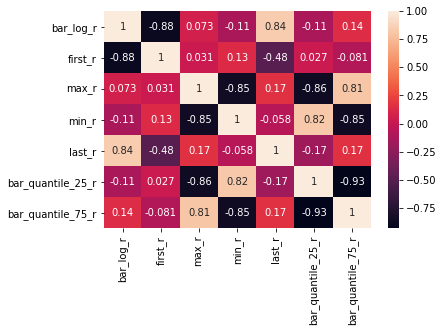

In [29]:
sns.heatmap(df_5m[['bar_log_r', 'first_r', 'max_r', 'min_r', 'last_r', 'bar_quantile_25_r', 'bar_quantile_75_r']].corr(method='pearson'), annot=True);

In [60]:
# standard deviations of the return-like features - aggregated features has lower std
df_5m[['bar_log_r', 'first_r', 'max_r', 'min_r', 'last_r', 'bar_quantile_25_r', 'bar_quantile_75_r']].std()

bar_log_r            0.000489
first_r              0.000302
max_r                0.000268
min_r                0.000258
last_r               0.000266
bar_quantile_25_r    0.000115
bar_quantile_75_r    0.000125
dtype: float64

## Data Augmentation

When training deep learning models on time series we have to face two problems. The dataset can be too short to feed a data-hungry neural network and training on too old data sometimes can be worse than dropping it.

Augmenting the data can help to increase the number of samples. With available tick data we can sample bars from any tick. For example instead of using hourly bars only with 17:00-18:00 ranges we can sample bar sequences where the hourly ranges are from (x:41) - (x+1:41), or even for every possible closing tick.

In the chart below we can compare a sequence of 5 min bars, and an other sequence of 5 min bars shifted by 2 mins. The charts are similar at first, but if we examine them closly we can notice differencies, and these differencies can be very large if we compare only candles to candles.

In [30]:
# resample 5 min data with 2 min shift
rs_5m_sft2 = df.resample('5min', base=2)
df_5m_sft2 = rs_5m_sft2.agg({ 'Ask price':    ['first',
                                    'max',
                                    'min',
                                    'last',
                                    'mean', 
                                    'std',
                                    bar_len,
                                    bar_quantile_25,
                                    bar_quantile_75,
                                    bar_spearman]})
df_5m_sft2 = df_5m_sft2['Ask price']
df_5m_sft2['bar_log_r'] = np.log(df_5m_sft2['first']/df_5m_sft2['last'])
df_5m_sft2 = df_5m_sft2[['first', 'max', 'min', 'last', 'mean', 'std', 'bar_len','bar_quantile_25', 'bar_quantile_75', 'bar_spearman', 'bar_log_r']]
df_5m_aux_sft2 = np.log(df_5m_sft2[['first', 'max', 'min', 'last', 'bar_quantile_25', 'bar_quantile_75']].div(df_5m_sft2['mean'], axis=0))
df_5m_aux_sft2 = df_5m_aux_sft2.rename(columns={  'first':'first_r',
                            'max':'max_r', 
                            'min':'min_r', 
                            'last':'last_r', 
                            'bar_quantile_25':'bar_quantile_25_r', 
                            'bar_quantile_75':'bar_quantile_75_r'})
df_5m_sft2 = pd.concat([df_5m_sft2, df_5m_aux_sft2], axis=1, join='inner')


In [31]:
# Fig4
fig4 = make_subplots(specs=[[{"secondary_y": True}]])
fig4.add_trace(go.Candlestick(x=df_5m_aux[5050:5100].index,
                open=df_5m['first_r'][5050:5100],
                high=df_5m['max_r'][5050:5100],
                low=df_5m['min_r'][5050:5100],
                close=df_5m['last_r'][5050:5100],
                increasing_line_color= 'red', decreasing_line_color= 'blue',
                name="OHLC r"))
fig4.add_trace(go.Candlestick(x=df_5m[5050:5100].index,
                open=df_5m[5050:5100]['bar_quantile_75_r'],
                high=df_5m[5050:5100]['bar_quantile_75_r'],
                low=df_5m[5050:5100]['bar_quantile_25_r'],
                close=df_5m[5050:5100]['bar_quantile_25_r'],
                increasing_line_color= 'gray', decreasing_line_color= 'gray',
                name="25-75 quantiles r"))
fig4.add_trace(go.Scatter(
                x=df_5m[5050:5100].index,
                y=df_5m[5050:5100]['mean'],
                name="bar mean"),
                secondary_y=True)

fig4.update(layout_xaxis_rangeslider_visible=False)
fig4.update_layout(
    autosize=False,
    width=1200,
    height=600,
    margin=dict(l=10,r=10,b=10,t=10))
fig4.show()

# Fig5
fig5 = make_subplots(specs=[[{"secondary_y": True}]])
fig5.add_trace(go.Candlestick(x=df_5m_sft2[5050:5100].index,
                open=df_5m_sft2['first_r'][5050:5100],
                high=df_5m_sft2['max_r'][5050:5100],
                low=df_5m_sft2['min_r'][5050:5100],
                close=df_5m_sft2['last_r'][5050:5100],
                increasing_line_color= 'red', decreasing_line_color= 'blue',
                name="OHLC r"))
fig5.add_trace(go.Candlestick(x=df_5m_sft2[5050:5100].index,
                open=df_5m_sft2[5050:5100]['bar_quantile_75_r'],
                high=df_5m_sft2[5050:5100]['bar_quantile_75_r'],
                low=df_5m_sft2[5050:5100]['bar_quantile_25_r'],
                close=df_5m_sft2[5050:5100]['bar_quantile_25_r'],
                increasing_line_color= 'gray', decreasing_line_color= 'gray',
                name="25-75 quantiles r"))
fig5.add_trace(go.Scatter(
                x=df_5m_sft2[5050:5100].index,
                y=df_5m_sft2[5050:5100]['mean'],
                name="bar mean"),
                secondary_y=True)

fig5.update(layout_xaxis_rangeslider_visible=False)
fig5.update_layout(
    autosize=False,
    width=1200,
    height=600,
    margin=dict(l=10,r=10,b=10,t=10))
fig5.show()

## Sacrilege!!!

Let's break some rules, or at least sacrifice some advantage of the bars sampled after equal time periods, certain tick numbers, or predefined volumes.

Let's build a bar sequence, where the bars further in the past cover larger and larger ranges. 

But why would we do that? Because we want to enable our model to process a sequence of a very long period. If we use equally sampled bars, then for our forecast the last bar of the past denoted as "t" is the most important, and the earlier bar at "t-1" is probably very important as well. The bar at "t-46" and "t-47" alone can be relativelly unimportant, but some characteristic of the range between "t-40" and "t-50" can be usefull for the model. We can sample this full range as one bar. 

The range of a full input sequence can be very large this way. In the following calculations there are some simple examples how large ranges can be processed with this teqhnique. For example if our last bar is a one minute bar, and every earlier bar is longer by 1.1, then a 20 bar sequence is almost an hour. Instead of 60 1 minute bars we can use only 20 not equal length bars. But if our sequence is 100 bar long, then the range of our full sequence is 137796 minutes. This is more than 95 days!

These bar types have their strong disadvantages. These bars will distort or even abolish seasonality. If we have clearly seasonal data probably we should use other sampling methods. These bars need more computation power than the regularly sampled bars, because we need to calculate more bars of different ranges.

I have to admit that I didn't use this bar type earlier. This article is part of a squence of loosly/closly related articles I wrote and will write, and this idea belongs here. In the code below I show a simple implementation of these bars. Live implementation for model training will come later.

In [32]:
# calculate exponentialy growing numbers
bar_ranger = lambda start_bar, p_base, steps : [start_bar*p_base**i for i in range(steps)]

In [33]:
# just an example of ranges and the sum of ranges
print(bar_ranger(1,1.1,20))
print(sum(bar_ranger(1,1.1,20)))

[1.0, 1.1, 1.2100000000000002, 1.3310000000000004, 1.4641000000000004, 1.6105100000000006, 1.7715610000000008, 1.9487171000000012, 2.1435888100000016, 2.357947691000002, 2.5937424601000023, 2.8531167061100025, 3.138428376721003, 3.452271214393104, 3.7974983358324144, 4.177248169415656, 4.594972986357222, 5.054470284992945, 5.55991731349224, 6.115909044841464]
57.27499949325606


In [34]:
# an other example
print(sum(bar_ranger(1,1.1,100)))

137796.12339822372


In [35]:
# our working example: sum of ranges
print(sum(bar_ranger(5,1.08,50)))

2868.8507820769573


In [36]:
# ranges
bar_times = bar_ranger(5,1.08,50)
# starting zero for later calculations
bar_times.insert(0, 0)
bar_times

[0,
 5.0,
 5.4,
 5.832000000000001,
 6.298560000000001,
 6.802444800000002,
 7.346640384000002,
 7.9343716147200025,
 8.569121343897605,
 9.254651051409413,
 9.995023135522166,
 10.79462498636394,
 11.658194985273056,
 12.590850584094902,
 13.598118630822496,
 14.685968121288296,
 15.86084557099136,
 17.12971321667067,
 18.500090274004325,
 19.98009749592467,
 21.578505295598646,
 23.304785719246542,
 25.169168576786266,
 27.18270206292917,
 29.357318227963503,
 31.705903686200585,
 34.242375981096636,
 36.981766059584366,
 39.940307344351126,
 43.135531931899216,
 46.586374486451156,
 50.31328444536725,
 54.33834720099664,
 58.68541497707636,
 63.380248175242485,
 68.45066802926189,
 73.92672147160285,
 79.84085918933107,
 86.22812792447758,
 93.12637815843578,
 100.57648841111063,
 108.6226074839995,
 117.31241608271947,
 126.69740936933704,
 136.833202118884,
 147.77985828839473,
 159.60224695146633,
 172.37042670758365,
 186.16006084419035,
 201.0528657117256,
 217.13709496866363]

In [37]:
# ranges to timedelta
bar_times = pd.to_timedelta(bar_times, unit='min')
bar_times

TimedeltaIndex([       '00:00:00',        '00:05:00',        '00:05:24',
                '00:05:49.920000', '00:06:17.913600', '00:06:48.146688',
                '00:07:20.798423', '00:07:56.062296', '00:08:34.147280',
                '00:09:15.279063', '00:09:59.701388', '00:10:47.677499',
                '00:11:39.491699', '00:12:35.451035', '00:13:35.887117',
                '00:14:41.158087', '00:15:51.650734', '00:17:07.782793',
                '00:18:30.005416', '00:19:58.805849', '00:21:34.710317',
                '00:23:18.287143', '00:25:10.150114', '00:27:10.962123',
                '00:29:21.439093', '00:31:42.354221', '00:34:14.542558',
                '00:36:58.905963', '00:39:56.418440', '00:43:08.131915',
                '00:46:35.182469', '00:50:18.797066', '00:54:20.300832',
                '00:58:41.124898', '01:03:22.814890', '01:08:27.040081',
                '01:13:55.603288', '01:19:50.451551', '01:26:13.687675',
                '01:33:07.582689', '01:40:34.589304

In [38]:
# cumulative sum of ranges
cumsum_range = np.cumsum(bar_times)
cumsum_range

TimedeltaIndex([       '0 days 00:00:00',        '0 days 00:05:00',
                       '0 days 00:10:24', '0 days 00:16:13.920000',
                '0 days 00:22:31.833600', '0 days 00:29:19.980288',
                '0 days 00:36:40.778711', '0 days 00:44:36.841007',
                '0 days 00:53:10.988288', '0 days 01:02:26.267351',
                '0 days 01:12:25.968739', '0 days 01:23:13.646238',
                '0 days 01:34:53.137938', '0 days 01:47:28.588973',
                '0 days 02:01:04.476090', '0 days 02:15:45.634178',
                '0 days 02:31:37.284912', '0 days 02:48:45.067705',
                '0 days 03:07:15.073121', '0 days 03:27:13.878971',
                '0 days 03:48:48.589289', '0 days 04:12:06.876432',
                '0 days 04:37:17.026547', '0 days 05:04:27.988670',
                '0 days 05:33:49.427764', '0 days 06:05:31.781985',
                '0 days 06:39:46.324544', '0 days 07:16:45.230508',
                '0 days 07:56:41.648948', '0 day

In [39]:
def exp_resampler(i, cumsum_range, df, column_name):
    '''
    This function creates bars from tickdata
    The start and end dates of the bars are calculated from the subsequent cumsum ranges
    The cumsum_range can be any increasing timedelta series, so we can sample unequel length bars

    Parameters:
    i (int): index of the starting tick
    cumsum_range (TimedeltaIndex): bar time borders
    df (Dataframe): dataframe with tickdata
    column_name (string): name of column to sample

    Return:
    df_data (Dataframe): dataframe of sampled candles
    '''
    df_data = pd.DataFrame(columns=[    "start", 
                                        "end", 
                                        "timedelta",
                                        "ticks", "open", "high", "low", "close", "mean", "std"])
    seq_limits = [(df[i:i+1].index - st) for st in cumsum_range]
    for idx, limit in enumerate(seq_limits):
        if idx>0:
            df_work = df.loc[seq_limits[idx][0] : seq_limits[idx-1][0]]
            row = { "start" :seq_limits[idx][0],
                    "end" : seq_limits[idx-1][0],
                    "timedelta" : seq_limits[idx-1][0] - seq_limits[idx][0],
                    "ticks" : df_work[column_name].shape[0], 
                    "open" : df_work[column_name].iloc[0], 
                    "high" : df_work[column_name].max(), 
                    "low" : df_work[column_name].min(), 
                    "close" : df_work[column_name].iloc[-1], 
                    "mean" : df_work[column_name].mean(),
                    "std" : df_work[column_name].std()}        
            df_data = df_data.append(row, ignore_index=True)
    return df_data

In [40]:
# check last tick to sample, and the time of the last tick
df.iloc[2000000]

Ask price    118.46
Name: 2016-01-26 21:13:54, dtype: float64

In [41]:
# sample one sequence
df_exp = exp_resampler(2000000, cumsum_range, df, 'Ask price')
df_exp.shape

(50, 10)

In [42]:
# Fig6
# chart is zoomable - hover right top
fig6 = make_subplots(specs=[[{"secondary_y": True}]])
fig6.add_trace(go.Candlestick(x=df_exp['start'],
                open=df_exp['open'],
                high=df_exp['high'],
                low=df_exp['low'],
                close=df_exp['close'],
                increasing_line_color= 'red', decreasing_line_color= 'blue',
                name="OHLC exp"))
fig6.add_trace(go.Scatter(
                x=df_exp['start'],
                y=df_exp['mean'],
                marker_color="purple",
                name="bar mean"))

fig6.update_layout(
    autosize=False,
    width=1200,
    height=600,
    margin=dict(l=10,r=10,b=10,t=10))
fig6.show()